In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.DataFrame(columns=['Text','Label'])
with open("/content/assignment_4.txt", "r",encoding = "ISO-8859-1") as fin:
    for line in fin:
        text, label = line.strip().rsplit("@", 1)
        label = label.lstrip()
        d = {'Text': text, 'Label': label}
        ser = pd.Series(data=d)
        df = df.append(d, ignore_index=True)

In [ ]:
'''a. Use the original training and test data of the previous section (before any
transformations)'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'],
                                                    stratify=df['Label'],
                                                    test_size=0.30)


In [ ]:
'''b. Install the transformers library from huggingface:
pip install transformers[torch]'''
!pip3 install transformers[torch]

     |████████████████████████████████| 3.1 MB 8.9 MB/s 
     |████████████████████████████████| 895 kB 43.4 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 73.9 MB/s 
     |████████████████████████████████| 3.3 MB 53.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
'''c. Download a pre-trained BERT for Sequence Classification model'''
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

#df = pd.read_csv('data/title_conference.csv')
df.head()


,Text,Label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

#df = pd.read_csv('data/title_conference.csv')
df['Label'].value_counts()

neutral     1391
positive     570
negative     303
Name: Label, dtype: int64

In [ ]:
possible_labels = df.Label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'negative': 2, 'neutral': 0, 'positive': 1}

In [ ]:
df['label'] = df.Label.replace(label_dict)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.30,
                                                  random_state=42,
                                                  stratify=df.label.values)
X_test, X_Val, y_test, y_Val = train_test_split(  X_val,
                                                  y_val,
                                                  test_size=0.5,
                                                  random_state=42,
                                                  stratify=y_val)
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['Label', 'label', 'data_type']).count()

Text
Label    label data_type      
negative 2     train       212
               val          91
neutral  0     train       973
               val         418
positive 1     train       399
               val         171

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    max_length=512,
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    max_length=512,
    return_tensors='pt',
    truncation=True
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

**4d. Train the model using the original training data from above. Training loop**


In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        #probs = F.softmax(all_logits, dim=1).cpu().numpy()
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/642 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.12419195022238882
Validation loss: 0.24776899615014708
F1 Score (Weighted): 0.9535110075453352


Epoch 2:   0%|          | 0/642 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.06476350198935056
Validation loss: 0.24776899615014708
F1 Score (Weighted): 0.9535110075453352


In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


**The loss has reduced in the second epoch. I have run for 2 epochs as I have only cpu availability**

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

In [ ]:
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
#for epoch1 model
accuracy_per_class(predictions, true_vals)

model.predict()

Class: neutral
Accuracy: 198/209

Class: positive
Accuracy: 82/86

Class: negative
Accuracy: 44/45



In [ ]:
#for epoch2 model
accuracy_per_class(predictions, true_vals)

Class: neutral
Accuracy: 198/209

Class: positive
Accuracy: 82/86

Class: negative
Accuracy: 44/45



In [ ]:
pd.DataFrame(_).value_counts()

0    209
1     86
2     45
dtype: int64

In [ ]:
pd.DataFrame(true_vals).value_counts()

0    209
1     86
2     45
dtype: int64

# Question 3 begins here


a. Install the shapley python package

In [ ]:
!pip3 install shap

     |████████████████████████████████| 371 kB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509257 sha256=c9c4da854d80c1908efa8936bc0fac174b100552a70734b39e4481c23d558239
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(model)
shapp=explainer(model)

In [ ]:
explainer1 = shap.Explainer(evaluate, tokenizer)

**Creating the naive Bayes classifier from question 1**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'],
                                                    stratify=df['Label'],
                                                    test_size=0.30)
#filtering the data to remove all stopwords
stop_words = set(stopwords.words('english'))

X_train_filtered = X_train.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

X_test_filtered = X_test.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
from sklearn.feature_extraction.text import CountVectorizer
#single word count vectorizer
vectorizer = CountVectorizer(binary=True)
X_train_vect = vectorizer.fit_transform(X_train_filtered)
X_test_vect = vectorizer.transform(X_test_filtered)
#printing the vocabulary
vectorizer.get_feature_names_out()
#Training bernoulliNB on count vectorizer
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train_vect, y_train)
pred = clf.predict(X_test_vect)
accuracy_score(y_test, pred)

0.7602941176470588

d.) Applying shapely to Naive bayes classifier from Q1

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
Attribute `intercept_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


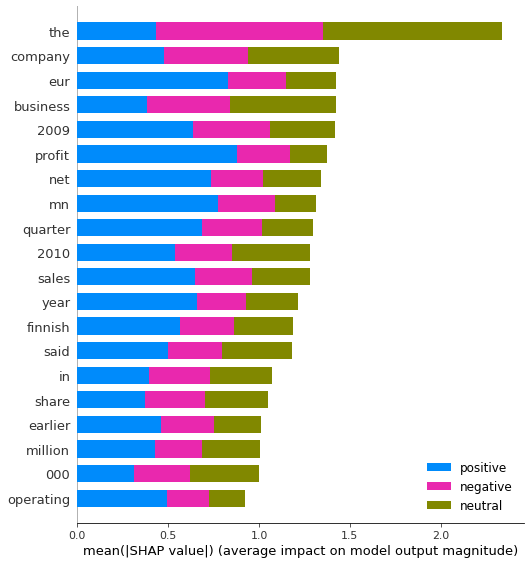

In [ ]:
masker = shap.maskers.Independent(data=X_test_vect)
explainer = shap.Explainer(clf, masker=masker)
shap_values = explainer.shap_values(X_test_vect)
X_test_array = X_test_vect.toarray()

shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names(), class_names=df['Label'].unique())

Yes, NB and BERT have different calling parameters for the shapely model.